In [2]:
import numpy as np
import pandas as pd
x_data = np.arange(200,2400)

spf_dict = {'2 HO2 <=> H2O2 + O2': {'A': 13000.0,
  'Ea': -3628.04407,
  'c': 93390973.44,
  'd': -0.000732521,
  'f': 8.2e-12,
  'n': 1.997152351},
 '2 OH <=> H2O + O': {'A': 354.5770856,
  'Ea': -1836.492972,
  'c': 12010735.18,
  'd': -4.87e-05,
  'f': 1.22e-12,
  'n': 2.938741717},
 'CH3 + HO2 <=> CH3O + OH': {'A': 838000000000.0,
  'Ea': -785.45,
  'c': 0.0,
  'd': 0.0,
  'f': 0.0,
  'n': 0.29},
 'CH3 + HO2 <=> CH4 + O2': {'A': 3190.0,
  'Ea': -4080.73,
  'c': 0.0,
  'd': 0.0,
  'f': 0.0,
  'n': 2.670857},
 'H2O2 + OH <=> H2O + HO2': {'A': 4.64e-06,
  'Ea': -5440.266692,
  'c': 126875776.1,
  'd': 0.000441194,
  'f': -5.35e-13,
  'n': 5.605491008},
 'HO2 + OH <=> H2O + O2': {'A': 1.41e+18,
  'Ea': -232.0064051,
  'c': 15243859.12,
  'd': -0.001187694,
  'f': 8.01e-12,
  'n': -2.05344973}}

In [3]:
def calculate_six_parameter_fit(reaction,dictonary,temperature):
    #finish editing this 
    #calc Ea,c,d,F seprately 
    A = dictonary[reaction]['A']
    n = dictonary[reaction]['n']
    Ea_temp = dictonary[reaction]['Ea']/(1.987*temperature)
    c_temp = dictonary[reaction]['c']/((1.987*temperature)**3)
    d_temp = dictonary[reaction]['d']*(1.987*temperature)
    f_temp = dictonary[reaction]['f']* ((1.987*temperature)**3)
            

    k = A*(temperature**n)*np.exp(-Ea_temp-c_temp-d_temp-f_temp)
    return k 


In [4]:
def reduced_T( T, T_min, T_max):
    '''Calculate the reduced temperature.'''
    T = np.array(T)
    T_tilde = 2. * T ** (-1.0) - T_min ** (-1.0) - T_max ** (-1.0)
    T_tilde /= (T_max ** (-1.0) - T_min ** (-1.0))
    return T_tilde

In [5]:
def first_cheby_poly(x, n):
    '''Generate n-th order Chebyshev ploynominals of first kind.'''
    if n == 0: return 1
    elif n == 1: return x
    result = 2. * x * first_cheby_poly(x, 1) - first_cheby_poly(x, 0)
    m = 0
    while n - m > 2:
        result = 2. * x * result - first_cheby_poly(x, m+1)
        m += 1
    return result

In [6]:
def fit_cheby_poly_1d(n_T, k, T_ls):
    #T needs to be a lsit 
    '''Fit the Chebyshev polynominals to rate constants.
       Input rate constants vector k should be arranged based on pressure.'''
    cheb_mat = np.zeros((len(k), n_T))
    for m, T in enumerate(T_ls):
        T_min = T_ls[0]
        T_max = T_ls[-1]
        for i in range(n_T):
            T_tilde = reduced_T(T, T_min, T_max)
            T_cheb = first_cheby_poly(T_tilde, i)

            cheb_mat[m,i] =  T_cheb
            #log_k = np.log10(np.array(k))

            
    coef,b,c,d = np.linalg.lstsq(cheb_mat,k,rcond=-1)
    
    return coef

In [7]:
y_data = []
for temp in x_data:
    k = calculate_six_parameter_fit('CH3 + HO2 <=> CH3O + OH',spf_dict,temp)
    y_data.append(k)
y_data= np.array(y_data)
fit_cheby_poly_1d(15,np.log10(y_data),x_data).reshape(15,1)

array([[ 1.31662109e+01],
       [-2.54384613e-01],
       [ 3.83633733e-02],
       [ 1.41150450e-02],
       [ 5.84280977e-03],
       [ 2.57932476e-03],
       [ 1.18656607e-03],
       [ 5.60732157e-04],
       [ 2.71261972e-04],
       [ 1.32224061e-04],
       [ 6.64863470e-05],
       [ 3.20338513e-05],
       [ 1.76702712e-05],
       [ 6.44937442e-06],
       [ 7.14143478e-06]])

In [8]:
import cantera as ct
gas1 = ct.Solution('FFCM1_custom.cti')

reaction_list = gas1.reaction_equations()
y_data = []
for temp in x_data:
    gas1.TPX = temp,101325,{'Ar':1}
    y_data.append(gas1.forward_rate_constants[reaction_list.index('CH3 + HO2 <=> CH3O + OH')])

y_data= np.array(y_data)*1000
fit_cheby_poly_1d(15,np.log10(y_data),x_data).reshape(15,1)

array([[ 1.31661632e+01],
       [-2.54344201e-01],
       [ 3.83633733e-02],
       [ 1.41150450e-02],
       [ 5.84280977e-03],
       [ 2.57932476e-03],
       [ 1.18656607e-03],
       [ 5.60732157e-04],
       [ 2.71261972e-04],
       [ 1.32224061e-04],
       [ 6.64863470e-05],
       [ 3.20338513e-05],
       [ 1.76702712e-05],
       [ 6.44937443e-06],
       [ 7.14143478e-06]])

In [9]:
len_of_parameters = [8,7,13,10,3,2]
sum([8,7,13,10,3,2])

43

In [10]:
df = pd.read_csv('cheb_sensitivity_coef.csv')


In [11]:
#Reaction One
p0 = df['p0'].dropna().values.reshape(15,1)
p1 = df['p1'].dropna().values.reshape(15,1)
p2 = df['p2'].dropna().values.reshape(15,1)
p3 = df['p3'].dropna().values.reshape(15,1)
p4 = df['p4'].dropna().values.reshape(15,1)
p5 = df['p5'].dropna().values.reshape(15,1)
p6 = df['p6'].dropna().values.reshape(15,1)
p7 = df['p7'].dropna().values.reshape(15,1)


In [12]:
#Reaction Two
p8 = df['p8'].dropna().values.reshape(15,1)
p9 = df['p9'].dropna().values.reshape(15,1)
p10 = df['p10'].dropna().values.reshape(15,1)
p11 = df['p11'].dropna().values.reshape(15,1)
p12 = df['p12'].dropna().values.reshape(15,1)
p13 = df['p13'].dropna().values.reshape(15,1)
p14 = df['p14'].dropna().values.reshape(15,1)


In [13]:
#Reaction Three
p15 = df['p15'].dropna().values.reshape(15,1)
p16 = df['p16'].dropna().values.reshape(15,1)
p17 = df['p17'].dropna().values.reshape(15,1)
p18 = df['p18'].dropna().values.reshape(15,1)
p19 = df['p19'].dropna().values.reshape(15,1)
p20 = df['p20'].dropna().values.reshape(15,1)
p21 = df['p21'].dropna().values.reshape(15,1)
p22 = df['p22'].dropna().values.reshape(15,1)
p23 = df['p23'].dropna().values.reshape(15,1)
p24 = df['p24'].dropna().values.reshape(15,1)
p25 = df['p25'].dropna().values.reshape(15,1)
p26 = df['p26'].dropna().values.reshape(15,1)
p27 = df['p27'].dropna().values.reshape(15,1)

In [14]:
#Reaction Four
p28 = df['p28'].dropna().values.reshape(17,1)
p29 = df['p29'].dropna().values.reshape(17,1)
p30 = df['p30'].dropna().values.reshape(17,1)
p31 = df['p31'].dropna().values.reshape(17,1)
p32 = df['p32'].dropna().values.reshape(17,1)
p33 = df['p33'].dropna().values.reshape(17,1)
p34 = df['p34'].dropna().values.reshape(17,1)
p35 = df['p35'].dropna().values.reshape(17,1)
p36 = df['p36'].dropna().values.reshape(17,1)
p37 = df['p37'].dropna().values.reshape(17,1)

In [15]:
#Reaction Five
p38 = df['p38'].dropna().values.reshape(15,1)
p39 = df['p39'].dropna().values.reshape(15,1)
p40 = df['p40'].dropna().values.reshape(15,1)

In [16]:
#Reaction Six
p41 = df['p41'].dropna().values.reshape(15,1)
p42 = df['p42'].dropna().values.reshape(15,1)

In [17]:
ttl_list = [p0,p1,p2,p3,p4,p5,p6,p7,p8,
           p9,p10,p11,p12,p13,p14,
           p15,p16,p17,p18,p19,p20,
           p21,p22,p23,p24,p25,p26,
           p27,p28,p29,p30,p31,p32,
           p33,p34,p35,p36,p37,p38,
           p39,p40,p41,p42]

In [18]:
#convert the first value in the array
ttl_list_converted = []
for p in ttl_list:
    shape = p.shape[0]
    temp = np.zeros((shape,1))
    #temp[0,0] = 6
    p_prime = p*.01
    p_prime = p_prime - temp
    p_prime = p_prime*(1/.01)
    ttl_list_converted.append(p_prime)

In [19]:
from itertools import islice 
Inputt = iter(ttl_list_converted) 
Output = [list(islice(Inputt, elem)) for elem in len_of_parameters] 

In [20]:
len_of_parameters

[8, 7, 13, 10, 3, 2]

In [21]:
master_equation_reactions = ['H2O2 + OH <=> H2O + HO2',
                             '2 HO2 <=> H2O2 + O2',
                             'HO2 + OH <=> H2O + O2',
                             '2 OH <=> H2O + O',
                             'CH3 + HO2 <=> CH4 + O2',
                             'CH3 + HO2 <=> CH3O + OH']

In [22]:
#This returns the converted dictonary of sensitivity
dict(zip(master_equation_reactions,Output))


{'2 HO2 <=> H2O2 + O2': [array([[-3.66e-01],
         [ 1.93e-01],
         [ 7.33e-02],
         [ 1.40e-02],
         [-2.52e-03],
         [-3.12e-03],
         [-1.71e-03],
         [-6.22e-04],
         [ 2.88e-06],
         [ 2.14e-04],
         [ 3.09e-04],
         [ 2.27e-04],
         [ 2.41e-04],
         [ 8.09e-05],
         [ 2.03e-04]]), array([[-1.19e+00],
         [-3.42e-01],
         [-1.52e-01],
         [-4.37e-02],
         [ 5.42e-03],
         [ 9.56e-03],
         [ 7.03e-03],
         [ 4.22e-03],
         [ 2.27e-03],
         [ 1.13e-03],
         [ 5.00e-04],
         [ 2.11e-04],
         [ 4.14e-05],
         [ 2.37e-05],
         [-6.11e-05]]), array([[-1.07e+00],
         [-3.15e-01],
         [-1.31e-01],
         [-3.22e-02],
         [ 7.08e-04],
         [ 3.88e-03],
         [ 2.52e-03],
         [ 1.09e-03],
         [ 1.86e-04],
         [-1.69e-04],
         [-3.45e-04],
         [-2.68e-04],
         [-3.02e-04],
         [-1.00e-04],
         

In [23]:
from itertools import islice 
Inputt = iter([1,2,3,4,5,6,7]) 
[list(islice([2,1,3,1], elem)) for elem in [2,1,3,1]] 

[[2, 1], [2], [2, 1, 3], [2]]

In [24]:
{'H2O2 + OH <=> H2O + HO2': [np.array([[-3.00368e+02],
         [ 1.94000e-01],
         [ 7.57000e-02],
         [ 1.18000e-02],
         [-3.17000e-03],
         [-3.18000e-03],
         [-1.50000e-03],
         [-3.49000e-04],
         [ 2.61000e-04],
         [ 4.13000e-04],
         [ 4.66000e-04],
         [ 3.25000e-04],
         [ 3.23000e-04],
         [ 1.10000e-04],
         [ 2.60000e-04]]), np.array([[-3.011e+02],
         [-4.120e-01],
         [-1.790e-01],
         [-3.900e-02],
         [ 1.100e-02],
         [ 1.180e-02],
         [ 7.010e-03],
         [ 3.260e-03],
         [ 1.020e-03],
         [ 5.480e-05],
         [-4.270e-04],
         [-3.830e-04],
         [-4.840e-04],
         [-1.590e-04],
         [-4.490e-04]]), np.array([[-3.0101e+02],
         [-3.6000e-01],
         [-1.4300e-01],
         [-2.8500e-02],
         [ 1.9800e-03],
         [ 4.1000e-03],
         [ 2.1900e-03],
         [ 6.0200e-04],
         [-3.0600e-04],
         [-5.5700e-04],
         [-6.5800e-04],
         [-4.6400e-04],
         [-4.6900e-04],
         [-1.5900e-04],
         [-3.8400e-04]]), np.array([[-3.000748e+02],
         [-1.100000e-01],
         [-6.330000e-02],
         [-2.660000e-02],
         [-6.210000e-03],
         [-1.300000e-03],
         [ 3.220000e-05],
         [ 2.900000e-04],
         [ 2.630000e-04],
         [ 1.810000e-04],
         [ 1.150000e-04],
         [ 6.430000e-05],
         [ 4.030000e-05],
         [ 1.550000e-05],
         [ 1.830000e-05]]), np.array([[-2.9867e+02],
         [-1.1400e+00],
         [-2.3500e-01],
         [ 6.5800e-02],
         [ 4.0700e-02],
         [ 1.9900e-02],
         [ 5.8600e-03],
         [-7.7900e-04],
         [-3.4800e-03],
         [-3.5900e-03],
         [-3.3900e-03],
         [-2.2500e-03],
         [-2.0700e-03],
         [-7.1400e-04],
         [-1.5800e-03]]), np.array([[-2.999568e+02],
         [-4.500000e-02],
         [-3.480000e-03],
         [ 5.090000e-03],
         [ 1.290000e-03],
         [ 3.490000e-04],
         [-3.200000e-05],
         [-1.490000e-04],
         [-1.670000e-04],
         [-1.360000e-04],
         [-1.100000e-04],
         [-6.890000e-05],
         [-5.840000e-05],
         [-2.050000e-05],
         [-4.130000e-05]]), np.array([[-2.99795e+02],
         [-5.82000e-02],
         [-1.39000e-02],
         [-1.57000e-03],
         [-2.41000e-03],
         [-1.61000e-03],
         [-1.03000e-03],
         [-6.45000e-04],
         [-4.02000e-04],
         [-2.42000e-04],
         [-1.52000e-04],
         [-8.50000e-05],
         [-5.99000e-05],
         [-2.16000e-05],
         [-3.48000e-05]]), np.array([[-3.00191e+02],
         [ 9.01000e-02],
         [ 3.76000e-02],
         [ 5.63000e-03],
         [ 5.16000e-04],
         [-3.55000e-04],
         [-2.56000e-04],
         [-7.95000e-05],
         [ 3.89000e-05],
         [ 7.42000e-05],
         [ 9.04000e-05],
         [ 6.42000e-05],
         [ 6.61000e-05],
         [ 2.22000e-05],
         [ 5.48000e-05]])], '2 HO2 <=> H2O2 + O2': [np.array([[-3.00366e+02],
         [ 1.93000e-01],
         [ 7.33000e-02],
         [ 1.40000e-02],
         [-2.52000e-03],
         [-3.12000e-03],
         [-1.71000e-03],
         [-6.22000e-04],
         [ 2.88000e-06],
         [ 2.14000e-04],
         [ 3.09000e-04],
         [ 2.27000e-04],
         [ 2.41000e-04],
         [ 8.09000e-05],
         [ 2.03000e-04]]), np.array([[-3.0119e+02],
         [-3.4200e-01],
         [-1.5200e-01],
         [-4.3700e-02],
         [ 5.4200e-03],
         [ 9.5600e-03],
         [ 7.0300e-03],
         [ 4.2200e-03],
         [ 2.2700e-03],
         [ 1.1300e-03],
         [ 5.0000e-04],
         [ 2.1100e-04],
         [ 4.1400e-05],
         [ 2.3700e-05],
         [-6.1100e-05]]), np.array([[-3.0107e+02],
         [-3.1500e-01],
         [-1.3100e-01],
         [-3.2200e-02],
         [ 7.0800e-04],
         [ 3.8800e-03],
         [ 2.5200e-03],
         [ 1.0900e-03],
         [ 1.8600e-04],
         [-1.6900e-04],
         [-3.4500e-04],
         [-2.6800e-04],
         [-3.0200e-04],
         [-1.0000e-04],
         [-2.6400e-04]]), np.array([[-3.000614e+02],
         [-9.490000e-02],
         [-5.990000e-02],
         [-2.880000e-02],
         [-8.930000e-03],
         [-2.740000e-03],
         [-4.910000e-04],
         [ 2.290000e-04],
         [ 4.070000e-04],
         [ 3.590000e-04],
         [ 2.970000e-04],
         [ 1.870000e-04],
         [ 1.570000e-04],
         [ 5.560000e-05],
         [ 1.090000e-04]]), np.array([[-2.99205e+02],
         [-6.39000e-01],
         [-1.56000e-01],
         [ 1.45000e-02],
         [ 2.60000e-02],
         [ 1.54000e-02],
         [ 6.08000e-03],
         [ 1.07000e-03],
         [-1.28000e-03],
         [-1.76000e-03],
         [-1.88000e-03],
         [-1.29000e-03],
         [-1.24000e-03],
         [-4.25000e-04],
         [-9.81000e-04]]), np.array([[-2.999877e+02],
         [-1.170000e-02],
         [-1.810000e-03],
         [ 8.560000e-04],
         [ 5.160000e-04],
         [ 2.430000e-04],
         [ 7.040000e-05],
         [-9.290000e-06],
         [-4.110000e-05],
         [-4.230000e-05],
         [-3.980000e-05],
         [-2.630000e-05],
         [-2.420000e-05],
         [-8.350000e-06],
         [-1.840000e-05]]), np.array([[-3.00234e+02],
         [-9.60000e-03],
         [ 5.00000e-03],
         [ 1.00000e-02],
         [ 9.07000e-03],
         [ 5.40000e-03],
         [ 2.83000e-03],
         [ 1.36000e-03],
         [ 5.68000e-04],
         [ 2.03000e-04],
         [ 2.33000e-05],
         [-1.97000e-05],
         [-5.93000e-05],
         [-1.83000e-05],
         [-6.91000e-05]])], 'HO2 + OH <=> H2O + O2': [np.array([[-3.0017e+02],
         [ 3.8400e-02],
         [ 4.2600e-02],
         [ 1.8200e-02],
         [ 4.3200e-03],
         [ 7.7900e-04],
         [-2.2100e-04],
         [-4.0400e-04],
         [-3.6200e-04],
         [-2.6000e-04],
         [-1.8500e-04],
         [-1.0900e-04],
         [-8.2400e-05],
         [-2.9800e-05],
         [-5.1000e-05]]), np.array([[-3.00759e+02],
         [-2.49000e-01],
         [-2.67000e-02],
         [ 8.04000e-03],
         [ 1.66000e-02],
         [ 1.33000e-02],
         [ 9.17000e-03],
         [ 5.92000e-03],
         [ 3.75000e-03],
         [ 2.27000e-03],
         [ 1.43000e-03],
         [ 8.00000e-04],
         [ 5.59000e-04],
         [ 2.03000e-04],
         [ 3.21000e-04]]), np.array([[-3.00632e+02],
         [-2.16000e-01],
         [-3.63000e-02],
         [-1.84000e-03],
         [ 5.63000e-03],
         [ 4.83000e-03],
         [ 3.15000e-03],
         [ 1.84000e-03],
         [ 1.02000e-03],
         [ 5.38000e-04],
         [ 2.74000e-04],
         [ 1.33000e-04],
         [ 6.24000e-05],
         [ 2.49000e-05],
         [ 1.20000e-05]]), np.array([[-3.000591e+02],
         [-7.360000e-02],
         [-3.990000e-02],
         [-1.790000e-02],
         [-5.400000e-03],
         [-1.350000e-03],
         [ 7.570000e-05],
         [ 4.680000e-04],
         [ 5.110000e-04],
         [ 4.050000e-04],
         [ 3.190000e-04],
         [ 1.970000e-04],
         [ 1.630000e-04],
         [ 5.760000e-05],
         [ 1.120000e-04]]), np.array([[-2.99847e+02],
         [-6.92000e-02],
         [-4.99000e-02],
         [-1.59000e-02],
         [-6.22000e-04],
         [ 1.56000e-03],
         [ 1.41000e-03],
         [ 9.14000e-04],
         [ 5.15000e-04],
         [ 2.68000e-04],
         [ 1.25000e-04],
         [ 5.54000e-05],
         [ 1.55000e-05],
         [ 7.64000e-06],
         [-1.00000e-05]]), np.array([[-2.999722e+02],
         [-1.180000e-02],
         [-8.150000e-03],
         [-2.380000e-03],
         [-1.950000e-05],
         [ 2.730000e-04],
         [ 2.190000e-04],
         [ 1.300000e-04],
         [ 6.400000e-05],
         [ 2.770000e-05],
         [ 7.390000e-06],
         [ 9.300000e-07],
         [-4.400000e-06],
         [-1.170000e-06],
         [-6.580000e-06]]), np.array([[-3.00184e+02],
         [ 3.68000e-02],
         [ 2.98000e-02],
         [ 1.72000e-02],
         [ 4.96000e-03],
         [ 1.54000e-03],
         [ 3.35000e-04],
         [-4.96000e-05],
         [-1.50000e-04],
         [-1.39000e-04],
         [-1.16000e-04],
         [-7.32000e-05],
         [-6.06000e-05],
         [-2.16000e-05],
         [-4.14000e-05]]), np.array([[-3.000202e+02],
         [ 2.170000e-03],
         [ 4.600000e-03],
         [ 2.440000e-03],
         [ 7.980000e-04],
         [ 2.490000e-04],
         [ 3.890000e-05],
         [-3.070000e-05],
         [-4.820000e-05],
         [-4.200000e-05],
         [-3.510000e-05],
         [-2.220000e-05],
         [-1.890000e-05],
         [-6.650000e-06],
         [-1.340000e-05]]), np.array([[-3.00081e+02],
         [-7.70000e-02],
         [-3.76000e-02],
         [-1.62000e-02],
         [-5.08000e-03],
         [-1.48000e-03],
         [-1.87000e-04],
         [ 2.10000e-04],
         [ 2.95000e-04],
         [ 2.49000e-04],
         [ 2.01000e-04],
         [ 1.26000e-04],
         [ 1.05000e-04],
         [ 3.72000e-05],
         [ 7.27000e-05]]), np.array([[-3.000646e+02],
         [-4.720000e-02],
         [-1.720000e-02],
         [-4.680000e-03],
         [ 1.840000e-04],
         [ 7.630000e-04],
         [ 6.110000e-04],
         [ 3.840000e-04],
         [ 2.150000e-04],
         [ 1.120000e-04],
         [ 5.350000e-05],
         [ 2.440000e-05],
         [ 8.300000e-06],
         [ 3.750000e-06],
         [-2.290000e-06]]), np.array([[-3.0000364e+02],
         [-6.3200000e-03],
         [-4.5400000e-03],
         [-2.7700000e-03],
         [-1.4200000e-03],
         [-6.5100000e-04],
         [-2.5800000e-04],
         [-7.6800000e-05],
         [ 2.3100000e-06],
         [ 2.5200000e-05],
         [ 3.2900000e-05],
         [ 2.3600000e-05],
         [ 2.3600000e-05],
         [ 8.0900000e-06],
         [ 1.9000000e-05]]), np.array([[-3.00019e+02],
         [-7.17000e-03],
         [-3.13000e-03],
         [-1.14000e-03],
         [-3.30000e-04],
         [-1.12000e-04],
         [-4.32000e-05],
         [-2.01000e-05],
         [-1.19000e-05],
         [-7.62000e-06],
         [-5.77000e-06],
         [-3.54000e-06],
         [-3.14000e-06],
         [-1.06000e-06],
         [-2.37000e-06]]), np.array([[-2.999033e+02],
         [-6.580000e-02],
         [ 8.520000e-03],
         [ 9.690000e-03],
         [ 5.090000e-03],
         [ 2.600000e-03],
         [ 1.220000e-03],
         [ 5.230000e-04],
         [ 1.830000e-04],
         [ 4.150000e-05],
         [-2.280000e-05],
         [-2.790000e-05],
         [-3.990000e-05],
         [-1.310000e-05],
         [-3.840000e-05]])], '2 OH <=> H2O + O': [np.array([[-3.00439e+02],
         [ 3.19000e-01],
         [ 6.31000e-02],
         [-1.39000e-03],
         [-2.30000e-03],
         [-1.97000e-03],
         [-1.06000e-03],
         [-4.25000e-04],
         [-8.33000e-05],
         [ 6.07000e-05],
         [ 1.09000e-04],
         [ 1.02000e-04],
         [ 8.99000e-05],
         [ 5.88000e-05],
         [ 5.21000e-05],
         [ 1.83000e-05],
         [ 3.88000e-05]]), np.array([[-3.00519e+02],
         [-5.09000e-01],
         [-1.60000e-01],
         [-2.99000e-02],
         [ 1.90000e-03],
         [ 5.38000e-03],
         [ 3.86000e-03],
         [ 2.10000e-03],
         [ 9.36000e-04],
         [ 3.15000e-04],
         [ 1.50000e-05],
         [-8.46000e-05],
         [-1.23000e-04],
         [-9.14000e-05],
         [-9.42000e-05],
         [-3.24000e-05],
         [-7.85000e-05]]), np.array([[-3.00429e+02],
         [-3.49000e-01],
         [-4.89000e-02],
         [ 2.75000e-02],
         [ 1.72000e-02],
         [ 9.22000e-03],
         [ 3.99000e-03],
         [ 1.24000e-03],
         [-1.83000e-05],
         [-4.58000e-04],
         [-5.53000e-04],
         [-4.65000e-04],
         [-3.83000e-04],
         [-2.45000e-04],
         [-2.09000e-04],
         [-7.41000e-05],
         [-1.50000e-04]]), np.array([[-3.000445e+02],
         [-7.260000e-02],
         [-4.410000e-02],
         [-1.800000e-02],
         [-1.820000e-03],
         [ 7.550000e-04],
         [ 9.190000e-04],
         [ 6.280000e-04],
         [ 3.530000e-04],
         [ 1.750000e-04],
         [ 7.440000e-05],
         [ 2.590000e-05],
         [ 1.350000e-06],
         [-4.150000e-06],
         [-9.730000e-06],
         [-3.080000e-06],
         [-1.110000e-05]]), np.array([[-2.99144e+02],
         [-8.80000e-01],
         [-4.56000e-03],
         [ 5.01000e-02],
         [ 7.51000e-03],
         [ 1.31000e-03],
         [-8.53000e-05],
         [-2.40000e-04],
         [-1.42000e-04],
         [-4.73000e-05],
         [ 1.07000e-05],
         [ 2.99000e-05],
         [ 3.82000e-05],
         [ 2.78000e-05],
         [ 2.87000e-05],
         [ 9.80000e-06],
         [ 2.42000e-05]]), np.array([[-2.999065e+02],
         [-1.180000e-01],
         [ 2.210000e-02],
         [ 4.290000e-03],
         [-1.340000e-04],
         [-5.580000e-04],
         [-3.410000e-04],
         [-1.250000e-04],
         [ 7.620000e-07],
         [ 5.160000e-05],
         [ 6.570000e-05],
         [ 5.680000e-05],
         [ 4.820000e-05],
         [ 3.110000e-05],
         [ 2.720000e-05],
         [ 9.580000e-06],
         [ 2.000000e-05]]), np.array([[-3.000101e+02],
         [-1.410000e-02],
         [-6.020000e-03],
         [-4.320000e-04],
         [ 1.740000e-03],
         [ 1.260000e-03],
         [ 6.920000e-04],
         [ 3.220000e-04],
         [ 1.200000e-04],
         [ 2.450000e-05],
         [-1.590000e-05],
         [-2.520000e-05],
         [-2.690000e-05],
         [-1.870000e-05],
         [-1.780000e-05],
         [-6.200000e-06],
         [-1.390000e-05]]), np.array([[-3.000741e+02],
         [-1.320000e-01],
         [-1.000000e-01],
         [-6.310000e-02],
         [-3.140000e-02],
         [-1.490000e-02],
         [-6.510000e-03],
         [-2.470000e-03],
         [-6.460000e-04],
         [ 7.370000e-05],
         [ 3.160000e-04],
         [ 3.190000e-04],
         [ 2.870000e-04],
         [ 1.890000e-04],
         [ 1.670000e-04],
         [ 5.900000e-05],
         [ 1.230000e-04]]), np.array([[-3.000605e+02],
         [-1.060000e-01],
         [-7.830000e-02],
         [-4.700000e-02],
         [-2.000000e-02],
         [-8.520000e-03],
         [-3.220000e-03],
         [-8.930000e-04],
         [ 4.060000e-05],
         [ 3.330000e-04],
         [ 3.790000e-04],
         [ 3.090000e-04],
         [ 2.480000e-04],
         [ 1.570000e-04],
         [ 1.310000e-04],
         [ 4.650000e-05],
         [ 9.180000e-05]]), np.array([[-3.000112e+02],
         [-2.100000e-02],
         [-1.700000e-02],
         [-1.190000e-02],
         [-7.170000e-03],
         [-3.690000e-03],
         [-1.720000e-03],
         [-7.120000e-04],
         [-2.290000e-04],
         [-2.400000e-05],
         [ 5.380000e-05],
         [ 6.560000e-05],
         [ 6.390000e-05],
         [ 4.310000e-05],
         [ 3.930000e-05],
         [ 1.380000e-05],
         [ 2.980000e-05]])], 'CH3 + HO2 <=> CH4 + O2': [np.array([[-3.00593e+02],
         [ 5.01000e-01],
         [-1.38000e-04],
         [-5.06000e-05],
         [-2.10000e-05],
         [-9.25000e-06],
         [-4.26000e-06],
         [-2.01000e-06],
         [-9.73000e-07],
         [-4.74000e-07],
         [-2.38000e-07],
         [-1.15000e-07],
         [-6.34000e-08],
         [-2.31000e-08],
         [-2.56000e-08]]), np.array([[-3.00855e+02],
         [-6.19000e-01],
         [-4.88000e-02],
         [-1.80000e-02],
         [-7.43000e-03],
         [-3.28000e-03],
         [-1.51000e-03],
         [-7.13000e-04],
         [-3.45000e-04],
         [-1.68000e-04],
         [-8.46000e-05],
         [-4.07000e-05],
         [-2.25000e-05],
         [-8.20000e-06],
         [-9.08000e-06]]), np.array([[-2.999604e+02],
         [ 4.240000e-02],
         [ 2.040000e-02],
         [ 7.520000e-03],
         [ 3.110000e-03],
         [ 1.370000e-03],
         [ 6.320000e-04],
         [ 2.990000e-04],
         [ 1.440000e-04],
         [ 7.040000e-05],
         [ 3.540000e-05],
         [ 1.710000e-05],
         [ 9.410000e-06],
         [ 3.440000e-06],
         [ 3.800000e-06]])], 'CH3 + HO2 <=> CH3O + OH': [np.array([[-2.99571e+02],
         [ 3.64000e-03],
         [-5.66000e-03],
         [-2.08000e-03],
         [-8.63000e-04],
         [-3.81000e-04],
         [-1.75000e-04],
         [-8.28000e-05],
         [-4.01000e-05],
         [-1.95000e-05],
         [-9.82000e-06],
         [-4.73000e-06],
         [-2.61000e-06],
         [-9.52000e-07],
         [-1.05000e-06]]), np.array([[-2.99960753e+02],
         [ 4.28940000e-02],
         [ 1.99550000e-02],
         [ 7.34206000e-03],
         [ 3.03919000e-03],
         [ 1.34166000e-03],
         [ 6.17203000e-04],
         [ 2.91670000e-04],
         [ 1.41099000e-04],
         [ 6.88000000e-05],
         [ 3.46000000e-05],
         [ 1.67000000e-05],
         [ 9.19000000e-06],
         [ 3.35000000e-06],
         [ 3.71000000e-06]])]}

{'2 HO2 <=> H2O2 + O2': [array([[-3.00366e+02],
         [ 1.93000e-01],
         [ 7.33000e-02],
         [ 1.40000e-02],
         [-2.52000e-03],
         [-3.12000e-03],
         [-1.71000e-03],
         [-6.22000e-04],
         [ 2.88000e-06],
         [ 2.14000e-04],
         [ 3.09000e-04],
         [ 2.27000e-04],
         [ 2.41000e-04],
         [ 8.09000e-05],
         [ 2.03000e-04]]), array([[-3.0119e+02],
         [-3.4200e-01],
         [-1.5200e-01],
         [-4.3700e-02],
         [ 5.4200e-03],
         [ 9.5600e-03],
         [ 7.0300e-03],
         [ 4.2200e-03],
         [ 2.2700e-03],
         [ 1.1300e-03],
         [ 5.0000e-04],
         [ 2.1100e-04],
         [ 4.1400e-05],
         [ 2.3700e-05],
         [-6.1100e-05]]), array([[-3.0107e+02],
         [-3.1500e-01],
         [-1.3100e-01],
         [-3.2200e-02],
         [ 7.0800e-04],
         [ 3.8800e-03],
         [ 2.5200e-03],
         [ 1.0900e-03],
         [ 1.8600e-04],
         [-1.6900e-04],
  

In [25]:
{'2 HO2 <=> H2O2 + O2': [np.array([[-6.00366e+02],
         [ 1.93000e-01],
         [ 7.33000e-02],
         [ 1.40000e-02],
         [-2.52000e-03],
         [-3.12000e-03],
         [-1.71000e-03],
         [-6.22000e-04],
         [ 2.88000e-06],
         [ 2.14000e-04],
         [ 3.09000e-04],
         [ 2.27000e-04],
         [ 2.41000e-04],
         [ 8.09000e-05],
         [ 2.03000e-04]]), np.array([[-6.0119e+02],
         [-3.4200e-01],
         [-1.5200e-01],
         [-4.3700e-02],
         [ 5.4200e-03],
         [ 9.5600e-03],
         [ 7.0300e-03],
         [ 4.2200e-03],
         [ 2.2700e-03],
         [ 1.1300e-03],
         [ 5.0000e-04],
         [ 2.1100e-04],
         [ 4.1400e-05],
         [ 2.3700e-05],
         [-6.1100e-05]]), np.array([[-6.0107e+02],
         [-3.1500e-01],
         [-1.3100e-01],
         [-3.2200e-02],
         [ 7.0800e-04],
         [ 3.8800e-03],
         [ 2.5200e-03],
         [ 1.0900e-03],
         [ 1.8600e-04],
         [-1.6900e-04],
         [-3.4500e-04],
         [-2.6800e-04],
         [-3.0200e-04],
         [-1.0000e-04],
         [-2.6400e-04]]), array([[-6.000614e+02],
         [-9.490000e-02],
         [-5.990000e-02],
         [-2.880000e-02],
         [-8.930000e-03],
         [-2.740000e-03],
         [-4.910000e-04],
         [ 2.290000e-04],
         [ 4.070000e-04],
         [ 3.590000e-04],
         [ 2.970000e-04],
         [ 1.870000e-04],
         [ 1.570000e-04],
         [ 5.560000e-05],
         [ 1.090000e-04]]), np.array([[-5.99205e+02],
         [-6.39000e-01],
         [-1.56000e-01],
         [ 1.45000e-02],
         [ 2.60000e-02],
         [ 1.54000e-02],
         [ 6.08000e-03],
         [ 1.07000e-03],
         [-1.28000e-03],
         [-1.76000e-03],
         [-1.88000e-03],
         [-1.29000e-03],
         [-1.24000e-03],
         [-4.25000e-04],
         [-9.81000e-04]]), np.array([[-5.999877e+02],
         [-1.170000e-02],
         [-1.810000e-03],
         [ 8.560000e-04],
         [ 5.160000e-04],
         [ 2.430000e-04],
         [ 7.040000e-05],
         [-9.290000e-06],
         [-4.110000e-05],
         [-4.230000e-05],
         [-3.980000e-05],
         [-2.630000e-05],
         [-2.420000e-05],
         [-8.350000e-06],
         [-1.840000e-05]]), np.array([[-6.00234e+02],
         [-9.60000e-03],
         [ 5.00000e-03],
         [ 1.00000e-02],
         [ 9.07000e-03],
         [ 5.40000e-03],
         [ 2.83000e-03],
         [ 1.36000e-03],
         [ 5.68000e-04],
         [ 2.03000e-04],
         [ 2.33000e-05],
         [-1.97000e-05],
         [-5.93000e-05],
         [-1.83000e-05],
         [-6.91000e-05]])], '2 OH <=> H2O + O': [np.array([[-6.00439e+02],
         [ 3.19000e-01],
         [ 6.31000e-02],
         [-1.39000e-03],
         [-2.30000e-03],
         [-1.97000e-03],
         [-1.06000e-03],
         [-4.25000e-04],
         [-8.33000e-05],
         [ 6.07000e-05],
         [ 1.09000e-04],
         [ 1.02000e-04],
         [ 8.99000e-05],
         [ 5.88000e-05],
         [ 5.21000e-05],
         [ 1.83000e-05],
         [ 3.88000e-05]]), np.array([[-6.00519e+02],
         [-5.09000e-01],
         [-1.60000e-01],
         [-2.99000e-02],
         [ 1.90000e-03],
         [ 5.38000e-03],
         [ 3.86000e-03],
         [ 2.10000e-03],
         [ 9.36000e-04],
         [ 3.15000e-04],
         [ 1.50000e-05],
         [-8.46000e-05],
         [-1.23000e-04],
         [-9.14000e-05],
         [-9.42000e-05],
         [-3.24000e-05],
         [-7.85000e-05]]), np.array([[-6.00429e+02],
         [-3.49000e-01],
         [-4.89000e-02],
         [ 2.75000e-02],
         [ 1.72000e-02],
         [ 9.22000e-03],
         [ 3.99000e-03],
         [ 1.24000e-03],
         [-1.83000e-05],
         [-4.58000e-04],
         [-5.53000e-04],
         [-4.65000e-04],
         [-3.83000e-04],
         [-2.45000e-04],
         [-2.09000e-04],
         [-7.41000e-05],
         [-1.50000e-04]]), np.array([[-6.000445e+02],
         [-7.260000e-02],
         [-4.410000e-02],
         [-1.800000e-02],
         [-1.820000e-03],
         [ 7.550000e-04],
         [ 9.190000e-04],
         [ 6.280000e-04],
         [ 3.530000e-04],
         [ 1.750000e-04],
         [ 7.440000e-05],
         [ 2.590000e-05],
         [ 1.350000e-06],
         [-4.150000e-06],
         [-9.730000e-06],
         [-3.080000e-06],
         [-1.110000e-05]]), np.array([[-5.99144e+02],
         [-8.80000e-01],
         [-4.56000e-03],
         [ 5.01000e-02],
         [ 7.51000e-03],
         [ 1.31000e-03],
         [-8.53000e-05],
         [-2.40000e-04],
         [-1.42000e-04],
         [-4.73000e-05],
         [ 1.07000e-05],
         [ 2.99000e-05],
         [ 3.82000e-05],
         [ 2.78000e-05],
         [ 2.87000e-05],
         [ 9.80000e-06],
         [ 2.42000e-05]]), np.array([[-5.999065e+02],
         [-1.180000e-01],
         [ 2.210000e-02],
         [ 4.290000e-03],
         [-1.340000e-04],
         [-5.580000e-04],
         [-3.410000e-04],
         [-1.250000e-04],
         [ 7.620000e-07],
         [ 5.160000e-05],
         [ 6.570000e-05],
         [ 5.680000e-05],
         [ 4.820000e-05],
         [ 3.110000e-05],
         [ 2.720000e-05],
         [ 9.580000e-06],
         [ 2.000000e-05]]), array([[-6.000101e+02],
         [-1.410000e-02],
         [-6.020000e-03],
         [-4.320000e-04],
         [ 1.740000e-03],
         [ 1.260000e-03],
         [ 6.920000e-04],
         [ 3.220000e-04],
         [ 1.200000e-04],
         [ 2.450000e-05],
         [-1.590000e-05],
         [-2.520000e-05],
         [-2.690000e-05],
         [-1.870000e-05],
         [-1.780000e-05],
         [-6.200000e-06],
         [-1.390000e-05]]), np.array([[-6.000741e+02],
         [-1.320000e-01],
         [-1.000000e-01],
         [-6.310000e-02],
         [-3.140000e-02],
         [-1.490000e-02],
         [-6.510000e-03],
         [-2.470000e-03],
         [-6.460000e-04],
         [ 7.370000e-05],
         [ 3.160000e-04],
         [ 3.190000e-04],
         [ 2.870000e-04],
         [ 1.890000e-04],
         [ 1.670000e-04],
         [ 5.900000e-05],
         [ 1.230000e-04]]), np.array([[-6.000605e+02],
         [-1.060000e-01],
         [-7.830000e-02],
         [-4.700000e-02],
         [-2.000000e-02],
         [-8.520000e-03],
         [-3.220000e-03],
         [-8.930000e-04],
         [ 4.060000e-05],
         [ 3.330000e-04],
         [ 3.790000e-04],
         [ 3.090000e-04],
         [ 2.480000e-04],
         [ 1.570000e-04],
         [ 1.310000e-04],
         [ 4.650000e-05],
         [ 9.180000e-05]]), np.array([[-6.000112e+02],
         [-2.100000e-02],
         [-1.700000e-02],
         [-1.190000e-02],
         [-7.170000e-03],
         [-3.690000e-03],
         [-1.720000e-03],
         [-7.120000e-04],
         [-2.290000e-04],
         [-2.400000e-05],
         [ 5.380000e-05],
         [ 6.560000e-05],
         [ 6.390000e-05],
         [ 4.310000e-05],
         [ 3.930000e-05],
         [ 1.380000e-05],
         [ 2.980000e-05]])], 'CH3 + HO2 <=> CH3O + OH': [np.array([[-5.99571e+02],
         [ 3.64000e-03],
         [-5.66000e-03],
         [-2.08000e-03],
         [-8.63000e-04],
         [-3.81000e-04],
         [-1.75000e-04],
         [-8.28000e-05],
         [-4.01000e-05],
         [-1.95000e-05],
         [-9.82000e-06],
         [-4.73000e-06],
         [-2.61000e-06],
         [-9.52000e-07],
         [-1.05000e-06]]), np.array([[-5.99960753e+02],
         [ 4.28940000e-02],
         [ 1.99550000e-02],
         [ 7.34206000e-03],
         [ 3.03919000e-03],
         [ 1.34166000e-03],
         [ 6.17203000e-04],
         [ 2.91670000e-04],
         [ 1.41099000e-04],
         [ 6.88000000e-05],
         [ 3.46000000e-05],
         [ 1.67000000e-05],
         [ 9.19000000e-06],
         [ 3.35000000e-06],
         [ 3.71000000e-06]])], 'CH3 + HO2 <=> CH4 + O2': [np.array([[-6.00593e+02],
         [ 5.01000e-01],
         [-1.38000e-04],
         [-5.06000e-05],
         [-2.10000e-05],
         [-9.25000e-06],
         [-4.26000e-06],
         [-2.01000e-06],
         [-9.73000e-07],
         [-4.74000e-07],
         [-2.38000e-07],
         [-1.15000e-07],
         [-6.34000e-08],
         [-2.31000e-08],
         [-2.56000e-08]]),
  np.array([[-6.00855e+02],
         [-6.19000e-01],
         [-4.88000e-02],
         [-1.80000e-02],
         [-7.43000e-03],
         [-3.28000e-03],
         [-1.51000e-03],
         [-7.13000e-04],
         [-3.45000e-04],
         [-1.68000e-04],
         [-8.46000e-05],
         [-4.07000e-05],
         [-2.25000e-05],
         [-8.20000e-06],
         [-9.08000e-06]]),
  np.array([[-5.999604e+02],
         [ 4.240000e-02],
         [ 2.040000e-02],
         [ 7.520000e-03],
         [ 3.110000e-03],
         [ 1.370000e-03],
         [ 6.320000e-04],
         [ 2.990000e-04],
         [ 1.440000e-04],
         [ 7.040000e-05],
         [ 3.540000e-05],
         [ 1.710000e-05],
         [ 9.410000e-06],
         [ 3.440000e-06],
         [ 3.800000e-06]])], 'H2O2 + OH <=> H2O + HO2': [np.array([[-6.00368e+02],
         [ 1.94000e-01],
         [ 7.57000e-02],
         [ 1.18000e-02],
         [-3.17000e-03],
         [-3.18000e-03],
         [-1.50000e-03],
         [-3.49000e-04],
         [ 2.61000e-04],
         [ 4.13000e-04],
         [ 4.66000e-04],
         [ 3.25000e-04],
         [ 3.23000e-04],
         [ 1.10000e-04],
         [ 2.60000e-04]]), np.array([[-6.011e+02],
         [-4.120e-01],
         [-1.790e-01],
         [-3.900e-02],
         [ 1.100e-02],
         [ 1.180e-02],
         [ 7.010e-03],
         [ 3.260e-03],
         [ 1.020e-03],
         [ 5.480e-05],
         [-4.270e-04],
         [-3.830e-04],
         [-4.840e-04],
         [-1.590e-04],
         [-4.490e-04]]), np.array([[-6.0101e+02],
         [-3.6000e-01],
         [-1.4300e-01],
         [-2.8500e-02],
         [ 1.9800e-03],
         [ 4.1000e-03],
         [ 2.1900e-03],
         [ 6.0200e-04],
         [-3.0600e-04],
         [-5.5700e-04],
         [-6.5800e-04],
         [-4.6400e-04],
         [-4.6900e-04],
         [-1.5900e-04],
         [-3.8400e-04]]), np.array([[-6.000748e+02],
         [-1.100000e-01],
         [-6.330000e-02],
         [-2.660000e-02],
         [-6.210000e-03],
         [-1.300000e-03],
         [ 3.220000e-05],
         [ 2.900000e-04],
         [ 2.630000e-04],
         [ 1.810000e-04],
         [ 1.150000e-04],
         [ 6.430000e-05],
         [ 4.030000e-05],
         [ 1.550000e-05],
         [ 1.830000e-05]]), array([[-5.9867e+02],
         [-1.1400e+00],
         [-2.3500e-01],
         [ 6.5800e-02],
         [ 4.0700e-02],
         [ 1.9900e-02],
         [ 5.8600e-03],
         [-7.7900e-04],
         [-3.4800e-03],
         [-3.5900e-03],
         [-3.3900e-03],
         [-2.2500e-03],
         [-2.0700e-03],
         [-7.1400e-04],
         [-1.5800e-03]]), np.array([[-5.999568e+02],
         [-4.500000e-02],
         [-3.480000e-03],
         [ 5.090000e-03],
         [ 1.290000e-03],
         [ 3.490000e-04],
         [-3.200000e-05],
         [-1.490000e-04],
         [-1.670000e-04],
         [-1.360000e-04],
         [-1.100000e-04],
         [-6.890000e-05],
         [-5.840000e-05],
         [-2.050000e-05],
         [-4.130000e-05]]), np.array([[-5.99795e+02],
         [-5.82000e-02],
         [-1.39000e-02],
         [-1.57000e-03],
         [-2.41000e-03],
         [-1.61000e-03],
         [-1.03000e-03],
         [-6.45000e-04],
         [-4.02000e-04],
         [-2.42000e-04],
         [-1.52000e-04],
         [-8.50000e-05],
         [-5.99000e-05],
         [-2.16000e-05],
         [-3.48000e-05]]), np.array([[-6.00191e+02],
         [ 9.01000e-02],
         [ 3.76000e-02],
         [ 5.63000e-03],
         [ 5.16000e-04],
         [-3.55000e-04],
         [-2.56000e-04],
         [-7.95000e-05],
         [ 3.89000e-05],
         [ 7.42000e-05],
         [ 9.04000e-05],
         [ 6.42000e-05],
         [ 6.61000e-05],
         [ 2.22000e-05],
         [ 5.48000e-05]])], 'HO2 + OH <=> H2O + O2': [np.array([[-6.0017e+02],
         [ 3.8400e-02],
         [ 4.2600e-02],
         [ 1.8200e-02],
         [ 4.3200e-03],
         [ 7.7900e-04],
         [-2.2100e-04],
         [-4.0400e-04],
         [-3.6200e-04],
         [-2.6000e-04],
         [-1.8500e-04],
         [-1.0900e-04],
         [-8.2400e-05],
         [-2.9800e-05],
         [-5.1000e-05]]), np.array([[-6.00759e+02],
         [-2.49000e-01],
         [-2.67000e-02],
         [ 8.04000e-03],
         [ 1.66000e-02],
         [ 1.33000e-02],
         [ 9.17000e-03],
         [ 5.92000e-03],
         [ 3.75000e-03],
         [ 2.27000e-03],
         [ 1.43000e-03],
         [ 8.00000e-04],
         [ 5.59000e-04],
         [ 2.03000e-04],
         [ 3.21000e-04]]), np.array([[-6.00632e+02],
         [-2.16000e-01],
         [-3.63000e-02],
         [-1.84000e-03],
         [ 5.63000e-03],
         [ 4.83000e-03],
         [ 3.15000e-03],
         [ 1.84000e-03],
         [ 1.02000e-03],
         [ 5.38000e-04],
         [ 2.74000e-04],
         [ 1.33000e-04],
         [ 6.24000e-05],
         [ 2.49000e-05],
         [ 1.20000e-05]]), array([[-6.000591e+02],
         [-7.360000e-02],
         [-3.990000e-02],
         [-1.790000e-02],
         [-5.400000e-03],
         [-1.350000e-03],
         [ 7.570000e-05],
         [ 4.680000e-04],
         [ 5.110000e-04],
         [ 4.050000e-04],
         [ 3.190000e-04],
         [ 1.970000e-04],
         [ 1.630000e-04],
         [ 5.760000e-05],
         [ 1.120000e-04]]), np.array([[-5.99847e+02],
         [-6.92000e-02],
         [-4.99000e-02],
         [-1.59000e-02],
         [-6.22000e-04],
         [ 1.56000e-03],
         [ 1.41000e-03],
         [ 9.14000e-04],
         [ 5.15000e-04],
         [ 2.68000e-04],
         [ 1.25000e-04],
         [ 5.54000e-05],
         [ 1.55000e-05],
         [ 7.64000e-06],
         [-1.00000e-05]]), np.array([[-5.999722e+02],
         [-1.180000e-02],
         [-8.150000e-03],
         [-2.380000e-03],
         [-1.950000e-05],
         [ 2.730000e-04],
         [ 2.190000e-04],
         [ 1.300000e-04],
         [ 6.400000e-05],
         [ 2.770000e-05],
         [ 7.390000e-06],
         [ 9.300000e-07],
         [-4.400000e-06],
         [-1.170000e-06],
         [-6.580000e-06]]), np.array([[-6.00184e+02],
         [ 3.68000e-02],
         [ 2.98000e-02],
         [ 1.72000e-02],
         [ 4.96000e-03],
         [ 1.54000e-03],
         [ 3.35000e-04],
         [-4.96000e-05],
         [-1.50000e-04],
         [-1.39000e-04],
         [-1.16000e-04],
         [-7.32000e-05],
         [-6.06000e-05],
         [-2.16000e-05],
         [-4.14000e-05]]), np.array([[-6.000202e+02],
         [ 2.170000e-03],
         [ 4.600000e-03],
         [ 2.440000e-03],
         [ 7.980000e-04],
         [ 2.490000e-04],
         [ 3.890000e-05],
         [-3.070000e-05],
         [-4.820000e-05],
         [-4.200000e-05],
         [-3.510000e-05],
         [-2.220000e-05],
         [-1.890000e-05],
         [-6.650000e-06],
         [-1.340000e-05]]), np.array([[-6.00081e+02],
         [-7.70000e-02],
         [-3.76000e-02],
         [-1.62000e-02],
         [-5.08000e-03],
         [-1.48000e-03],
         [-1.87000e-04],
         [ 2.10000e-04],
         [ 2.95000e-04],
         [ 2.49000e-04],
         [ 2.01000e-04],
         [ 1.26000e-04],
         [ 1.05000e-04],
         [ 3.72000e-05],
         [ 7.27000e-05]]), np.array([[-6.000646e+02],
         [-4.720000e-02],
         [-1.720000e-02],
         [-4.680000e-03],
         [ 1.840000e-04],
         [ 7.630000e-04],
         [ 6.110000e-04],
         [ 3.840000e-04],
         [ 2.150000e-04],
         [ 1.120000e-04],
         [ 5.350000e-05],
         [ 2.440000e-05],
         [ 8.300000e-06],
         [ 3.750000e-06],
         [-2.290000e-06]]), np.array([[-6.0000364e+02],
         [-6.3200000e-03],
         [-4.5400000e-03],
         [-2.7700000e-03],
         [-1.4200000e-03],
         [-6.5100000e-04],
         [-2.5800000e-04],
         [-7.6800000e-05],
         [ 2.3100000e-06],
         [ 2.5200000e-05],
         [ 3.2900000e-05],
         [ 2.3600000e-05],
         [ 2.3600000e-05],
         [ 8.0900000e-06],
         [ 1.9000000e-05]]), np.array([[-6.00019e+02],
         [-7.17000e-03],
         [-3.13000e-03],
         [-1.14000e-03],
         [-3.30000e-04],
         [-1.12000e-04],
         [-4.32000e-05],
         [-2.01000e-05],
         [-1.19000e-05],
         [-7.62000e-06],
         [-5.77000e-06],
         [-3.54000e-06],
         [-3.14000e-06],
         [-1.06000e-06],
         [-2.37000e-06]]), np.array([[-5.999033e+02],
         [-6.580000e-02],
         [ 8.520000e-03],
         [ 9.690000e-03],
         [ 5.090000e-03],
         [ 2.600000e-03],
         [ 1.220000e-03],
         [ 5.230000e-04],
         [ 1.830000e-04],
         [ 4.150000e-05],
         [-2.280000e-05],
         [-2.790000e-05],
         [-3.990000e-05],
         [-1.310000e-05],
         [-3.840000e-05]])]}

NameError: name 'array' is not defined

Text(0.5,1,'CH3 + HO2 <=> CH3O + OH')

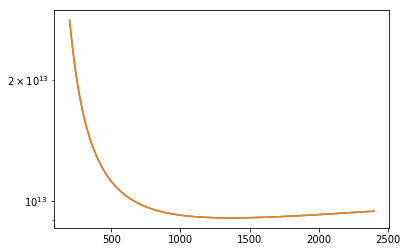

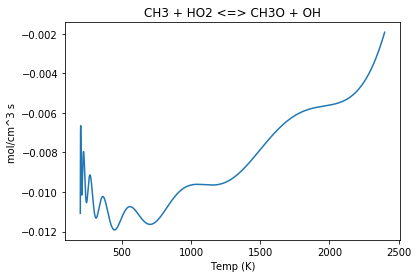

In [26]:
import cantera as ct
import matplotlib.pyplot as plt
gas1 = ct.Solution('FFCM1_custom.cti')
gas2 = ct.Solution('FFCM1_custom_cheb_test.cti')
reaction_list = gas1.reaction_equations()
y_data = []
y_data2 = []
for temp in x_data:
    gas1.TPX = temp,101325,{'Ar':1}
    gas2.TPX = temp, 101325,{'Ar':1}
    y_data.append(gas1.forward_rate_constants[reaction_list.index('CH3 + HO2 <=> CH3O + OH')])
    y_data2.append(gas2.forward_rate_constants[reaction_list.index('CH3 + HO2 <=> CH3O + OH')])
y_data= np.array(y_data)*1000
y_data2 = np.array(y_data2)*1000

plt.semilogy(x_data,y_data)
plt.semilogy(x_data,y_data2)


error = (y_data-y_data2)/y_data2
plt.figure()
plt.plot(x_data,error*100)
plt.xlabel('Temp (K)')
plt.ylabel('mol/cm^3 s ')
plt.title('CH3 + HO2 <=> CH3O + OH')

In [27]:
master_equation_reactions = ['H2O2 + OH <=> H2O + HO2',
                             '2 HO2 <=> H2O2 + O2',
                             'HO2 + OH <=> H2O + O2',
                             '2 OH <=> H2O + O',
                             'CH3 + HO2 <=> CH4 + O2',
                             'CH3 + HO2 <=> CH3O + OH']

83.90991282905924


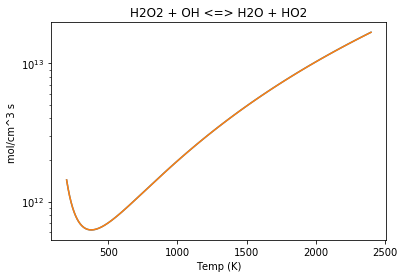

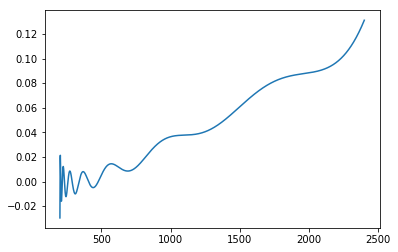

In [39]:
import cantera as ct
import matplotlib.pyplot as plt
gas1 = ct.Solution('FFCM1_custom.cti')
gas2 = ct.Solution('FFCM1_custom_cheb_test.cti')
reaction_list = gas1.reaction_equations()
reaction_list2 = gas2.reaction_equations()
y_data = []
y_data2 = []
for temp in x_data:
    gas1.TPX = temp,101325,{'Ar':1}
    gas2.TPX = temp, 101325,{'Ar':1}
    y_data.append(gas1.forward_rate_constants[reaction_list.index('H2O2 + OH <=> H2O + HO2')])
    y_data2.append(gas2.forward_rate_constants[reaction_list2.index('H2O2 + OH <=> H2O + HO2')])
y_data= np.array(y_data)*1000
y_data2 = np.array(y_data2)*1000

plt.semilogy(x_data,y_data)
plt.semilogy(x_data,y_data2)
plt.xlabel('Temp (K)')
plt.ylabel('mol/cm^3 s ')
plt.title('H2O2 + OH <=> H2O + HO2')

error = (y_data-y_data2)/y_data2
plt.figure()
plt.plot(x_data,error*100)

print(   (max(error)+1)*8.380000e+01   )



7.529254655155708


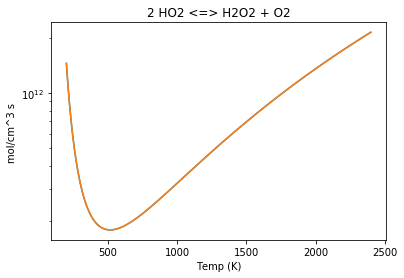

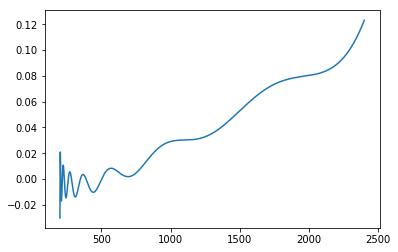

In [40]:
import cantera as ct
import matplotlib.pyplot as plt
gas1 = ct.Solution('FFCM1_custom.cti')
gas2 = ct.Solution('FFCM1_custom_cheb_test.cti')
reaction_list = gas1.reaction_equations()
reaction_list2 = gas2.reaction_equations()
y_data = []
y_data2 = []
for temp in x_data:
    gas1.TPX = temp,101325,{'Ar':1}
    gas2.TPX = temp, 101325,{'Ar':1}
    y_data.append(gas1.forward_rate_constants[reaction_list.index('2 HO2 <=> H2O2 + O2')])
    y_data2.append(gas2.forward_rate_constants[reaction_list2.index('2 HO2 <=> H2O2 + O2')])
y_data= np.array(y_data)*1000
y_data2 = np.array(y_data2)*1000

plt.semilogy(x_data,y_data)
plt.semilogy(x_data,y_data2)
plt.xlabel('Temp (K)')
plt.ylabel('mol/cm^3 s ')
plt.title('2 HO2 <=> H2O2 + O2')

error = (y_data-y_data2)/y_data2
plt.figure()
plt.plot(x_data,error*100)
print(   (max(error)+1)*7.520000e+00   )


1220829.428158235


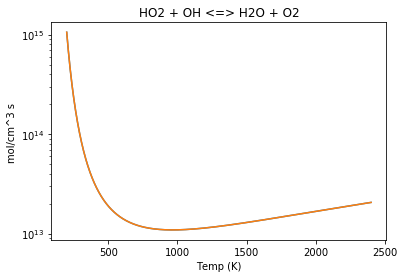

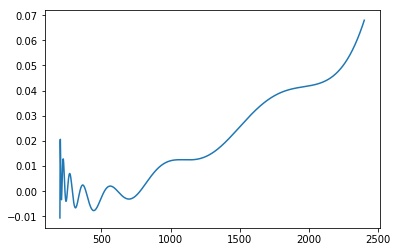

In [41]:
import cantera as ct
import matplotlib.pyplot as plt
gas1 = ct.Solution('FFCM1_custom.cti')
gas2 = ct.Solution('FFCM1_custom_cheb_test.cti')
reaction_list = gas1.reaction_equations()
y_data = []
y_data2 = []
for temp in x_data:
    gas1.TPX = temp,101325,{'Ar':1}
    gas2.TPX = temp, 101325,{'Ar':1}
    y_data.append(gas1.forward_rate_constants[reaction_list.index('HO2 + OH <=> H2O + O2')])
    y_data2.append(gas2.forward_rate_constants[reaction_list.index('HO2 + OH <=> H2O + O2')])
y_data= np.array(y_data)*1000
y_data2 = np.array(y_data2)*1000

plt.semilogy(x_data,y_data)
plt.semilogy(x_data,y_data2)
plt.xlabel('Temp (K)')
plt.ylabel('mol/cm^3 s ')
plt.title('HO2 + OH <=> H2O + O2')

error = (y_data-y_data2)/y_data2
plt.figure()
plt.plot(x_data,error*100)

print(   (max(error)+1)*1.220000e+06   )

1021.1202890253622


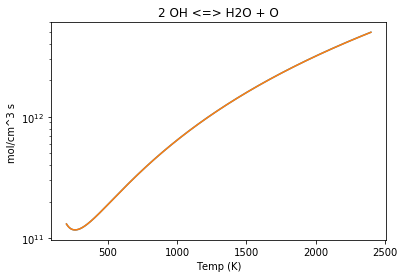

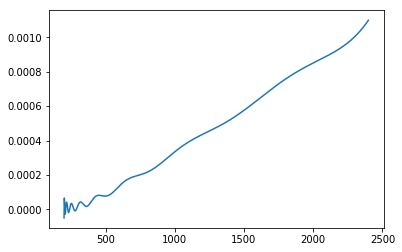

In [42]:
import cantera as ct
import matplotlib.pyplot as plt
gas1 = ct.Solution('FFCM1_custom.cti')
gas2 = ct.Solution('FFCM1_custom_cheb_test.cti')
reaction_list = gas1.reaction_equations()
y_data = []
y_data2 = []
for temp in x_data:
    gas1.TPX = temp,101325,{'Ar':1}
    gas2.TPX = temp, 101325,{'Ar':1}
    y_data.append(gas1.forward_rate_constants[reaction_list.index('2 OH <=> H2O + O')])
    y_data2.append(gas2.forward_rate_constants[reaction_list.index('2 OH <=> H2O + O')])
y_data= np.array(y_data)*1000
y_data2 = np.array(y_data2)*1000

plt.semilogy(x_data,y_data)
plt.semilogy(x_data,y_data2)
plt.xlabel('Temp (K)')
plt.ylabel('mol/cm^3 s ')
plt.title('2 OH <=> H2O + O')
error = (y_data-y_data2)/y_data2
plt.figure()
plt.plot(x_data,error)

print(   (max(error)+1)*1.020000e+03   )

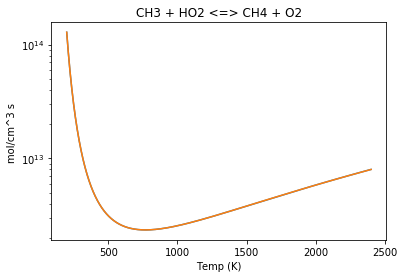

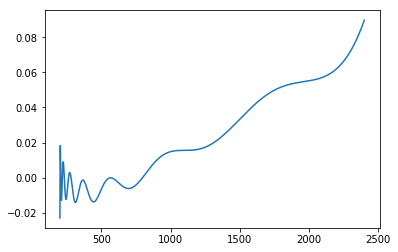

In [43]:
import cantera as ct
import matplotlib.pyplot as plt
gas1 = ct.Solution('FFCM1_custom.cti')
gas2 = ct.Solution('FFCM1_custom_cheb_test.cti')
reaction_list = gas1.reaction_equations()
y_data = []
y_data2 = []
for temp in x_data:
    gas1.TPX = temp,101325,{'Ar':1}
    gas2.TPX = temp, 101325,{'Ar':1}
    y_data.append(gas1.forward_rate_constants[reaction_list.index('CH3 + HO2 <=> CH4 + O2')])
    y_data2.append(gas2.forward_rate_constants[reaction_list.index('CH3 + HO2 <=> CH4 + O2')])
y_data= np.array(y_data)*1000
y_data2 = np.array(y_data2)*1000
plt.xlabel('Temp (K)')
plt.ylabel('mol/cm^3 s ')
plt.title('CH3 + HO2 <=> CH4 + O2')
plt.semilogy(x_data,y_data)
plt.semilogy(x_data,y_data2)


error = (y_data-y_data2)/y_data2
plt.figure()
plt.plot(x_data,error*100)

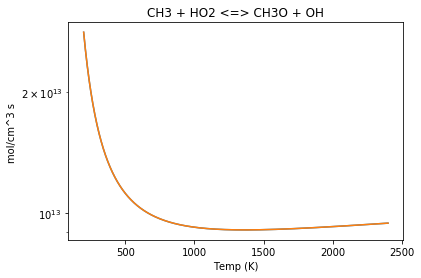

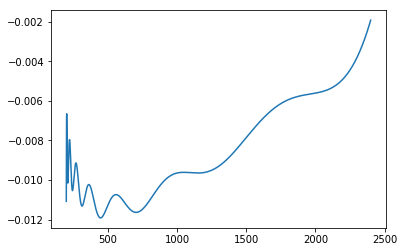

In [44]:
import cantera as ct
import matplotlib.pyplot as plt
gas1 = ct.Solution('FFCM1_custom.cti')
gas2 = ct.Solution('FFCM1_custom_cheb_test.cti')
reaction_list = gas1.reaction_equations()
y_data = []
y_data2 = []
for temp in x_data:
    gas1.TPX = temp,101325,{'Ar':1}
    gas2.TPX = temp, 101325,{'Ar':1}
    y_data.append(gas1.forward_rate_constants[reaction_list.index('CH3 + HO2 <=> CH3O + OH')])
    y_data2.append(gas2.forward_rate_constants[reaction_list.index('CH3 + HO2 <=> CH3O + OH')])
y_data= np.array(y_data)*1000
y_data2 = np.array(y_data2)*1000
plt.xlabel('Temp (K)')
plt.ylabel('mol/cm^3 s ')
plt.title('CH3 + HO2 <=> CH3O + OH')
plt.semilogy(x_data,y_data)
plt.semilogy(x_data,y_data2)


error = (y_data-y_data2)/y_data2
plt.figure()
plt.plot(x_data,error*100)

In [75]:
import cantera as ct
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def ShockTube(pressure,temperature,conditions,initialTime,finalTime,thermalBoundary,cti_file):
    gas = ct.Solution(cti_file)
    net_production_rate  = []
    forward_rates_of_progess_R1 =[]
    forward_rates_of_progess_R2 = []
    forward_rates_of_progess_R3 = []
    forward_rates_of_progess_R4 = []
    forward_rates_of_progess_R5 = []
    forward_rates_of_progess_R6 = []
    
    reverse_rates_of_progess_R1 =[]
    reverse_rates_of_progess_R2 = []
    reverse_rates_of_progess_R3 = []
    reverse_rates_of_progess_R4 = []
    reverse_rates_of_progess_R5 = []
    reverse_rates_of_progess_R6 = []
    
    gas.TPX = temperature, pressure*101325, conditions
    reaction_list = gas.reaction_equations()
    if thermalBoundary == 'adiabatic': 
        shockTube = ct.IdealGasConstPressureReactor(gas,name = 'R1',energy= 'on')
    elif thermalBoundary == 'isothermal': 
        shockTube = ct.IdealGasConstPressureReactor(gas,name = 'R1', energy= 'off')
    else:
        raise Exception('Please enter adiabatic or isothermal for the thermal boundary layer')
    
    
    sim=ct.ReactorNet([shockTube])
    


                      
        
    
    columnNames = [shockTube.component_name(item) for item in range(shockTube.n_vars)]  
    columnNames = ['time']+['pressure'] + columnNames
    timeHistory = pd.DataFrame(columns = columnNames)
    
   
    t=initialTime
    counter = 0
    #sim.atol =1e-60
    #sim.rtol = 1e-12

    while t < finalTime:
        t = sim.step() 
        state = np.hstack([t, shockTube.thermo.P, shockTube.mass, 
                    shockTube.T, shockTube.thermo.X])
        timeHistory.loc[counter] = state
        forward_rates_of_progess_R1.append(gas.forward_rates_of_progress[reaction_list.index('H2O2 + OH <=> H2O + HO2')])
        forward_rates_of_progess_R2.append(gas.forward_rates_of_progress[reaction_list.index('2 HO2 <=> H2O2 + O2')])
        forward_rates_of_progess_R3.append(gas.forward_rates_of_progress[reaction_list.index('HO2 + OH <=> H2O + O2')])
        forward_rates_of_progess_R4.append(gas.forward_rates_of_progress[reaction_list.index('2 OH <=> H2O + O')])
        forward_rates_of_progess_R5.append(gas.forward_rates_of_progress[reaction_list.index('CH3 + HO2 <=> CH4 + O2')])
        forward_rates_of_progess_R6.append(gas.forward_rates_of_progress[reaction_list.index('CH3 + HO2 <=> CH3O + OH')])
        
        
        reverse_rates_of_progess_R1.append(gas.reverse_rates_of_progress[reaction_list.index('H2O2 + OH <=> H2O + HO2')]) 
        reverse_rates_of_progess_R2.append(gas.reverse_rates_of_progress[reaction_list.index('2 HO2 <=> H2O2 + O2')]) 
        reverse_rates_of_progess_R3.append(gas.reverse_rates_of_progress[reaction_list.index('HO2 + OH <=> H2O + O2')]) 
        reverse_rates_of_progess_R4.append(gas.reverse_rates_of_progress[reaction_list.index('2 OH <=> H2O + O')]) 
        reverse_rates_of_progess_R5.append(gas.reverse_rates_of_progress[reaction_list.index('CH3 + HO2 <=> CH4 + O2')]) 
        reverse_rates_of_progess_R6.append(gas.reverse_rates_of_progress[reaction_list.index('CH3 + HO2 <=> CH3O + OH')]) 
        
        net_production_rate.append(gas.net_production_rates[gas.species_names.index('OH')])
        counter+=1
        
    frp_list = [forward_rates_of_progess_R1,forward_rates_of_progess_R2,forward_rates_of_progess_R3,forward_rates_of_progess_R4,
                   forward_rates_of_progess_R5,forward_rates_of_progess_R6]
    rrp_list = [reverse_rates_of_progess_R1,reverse_rates_of_progess_R2,reverse_rates_of_progess_R3,reverse_rates_of_progess_R4,
                   reverse_rates_of_progess_R5,reverse_rates_of_progess_R6]
    return timeHistory, frp_list,rrp_list,net_production_rate

In [76]:
timeHistory,frp_list,rrp_list,net_production_rate = ShockTube(1.909,1398, {'O2':0.00062 ,
                                     'H2O':0.001234,
                                     'H2O2':0.00254 ,
                                     'Ar': 0.9974968858350951},0,.0002,'adiabatic','FFCM1_custom.cti')



timeHistory2,frp_list2,rrp_list2,net_production_rate2 = ShockTube(1.909,1398, {'O2':0.00062 ,
                                     'H2O':0.001234,
                                     'H2O2':0.00254 ,
                                     'Ar': 0.9974968858350951},0,.0002,'adiabatic','FFCM1_custom_cheb_test.cti')


timeHistory3,frp_list3,rrp_list3,net_production_rate3 = ShockTube(1.909,1398, {'O2':0.00062 ,
                                     'H2O':0.001234,
                                     'H2O2':0.00254 ,
                                     'Ar': 0.9974968858350951},0,.0002,'adiabatic','FFCM1_custom_test_differences.cti')


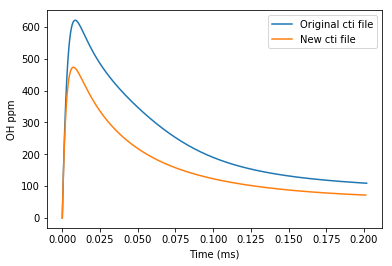

In [77]:
plt.plot(timeHistory['time']*1e3,timeHistory['OH']*1e6,label='Original cti file')
plt.plot(timeHistory2['time']*1e3,timeHistory2['OH']*1e6,label='New cti file')
plt.xlabel('Time (ms)')
plt.ylabel('OH ppm')
plt.legend()
#plt.plot(timeHistory3['time'],timeHistory3['OH']*1e6)

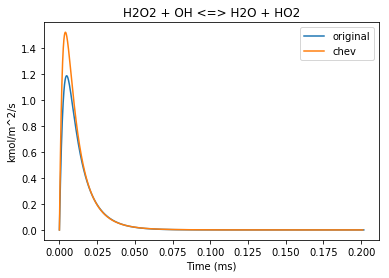

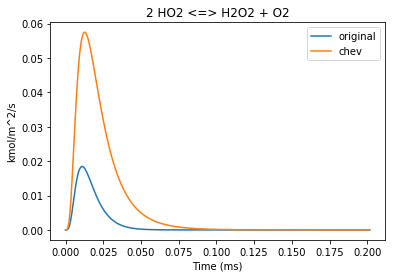

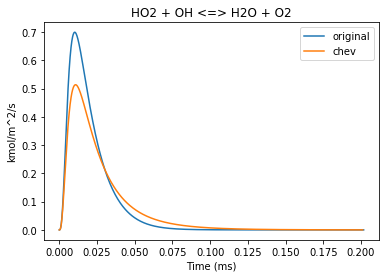

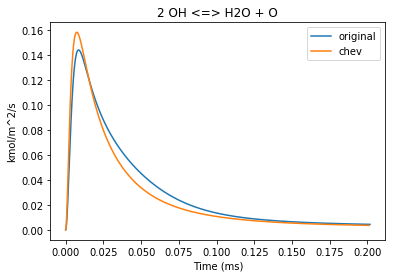

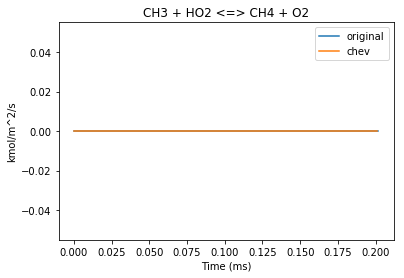

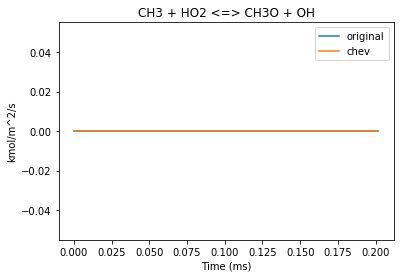

In [78]:
for i,frp in enumerate(frp_list):
    plt.figure()
    plt.plot(timeHistory['time']*1e3,frp,label='original')
    plt.plot(timeHistory2['time']*1e3,frp_list2[i],label='chev')
    plt.title(master_equation_reactions[i])
    plt.xlabel('Time (ms)')
    plt.ylabel('kmol/m^2/s')
    plt.legend()

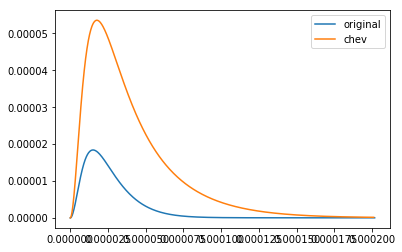

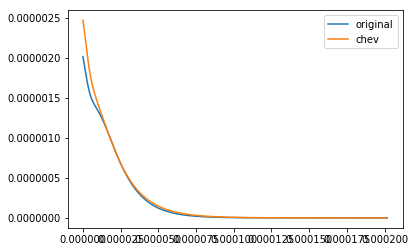

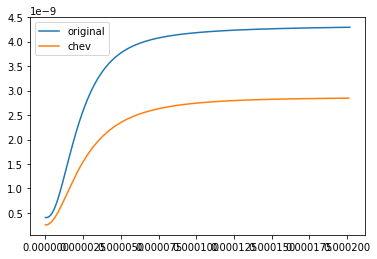

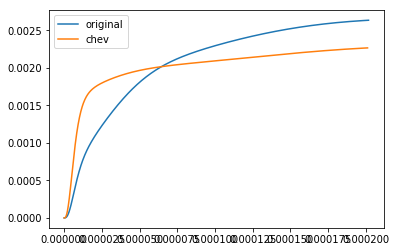

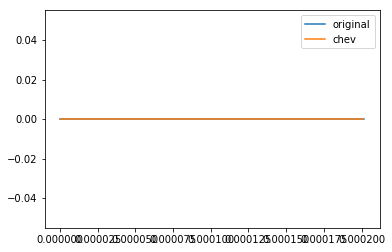

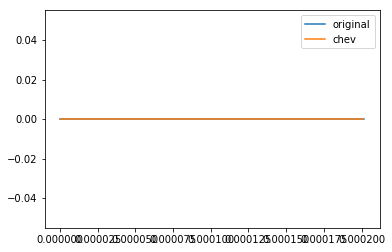

In [79]:
for i,rrp in enumerate(rrp_list):
    plt.figure()
    plt.plot(timeHistory['time'],rrp,label='original')
    plt.plot(timeHistory2['time'],rrp_list2[i],label='chev')
    plt.legend()

Text(0,0.5,'net production OH (kmol/m^2/s)')

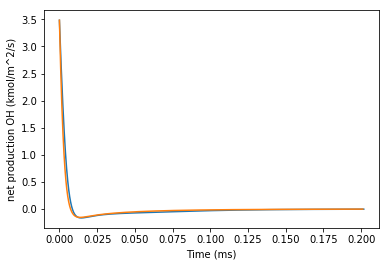

In [81]:
plt.plot(timeHistory['time']*1e3,net_production_rate)
plt.plot(timeHistory2['time']*1e3,net_production_rate2)
plt.xlabel('Time (ms)')
plt.ylabel('net production OH (kmol/m^2/s)')